In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from evalys import visu
from evalys.jobset import JobSet

In [3]:
input_location = 'KTH-io-aware-filter'
files_prefix = ''
# schedule_names = ['backfill-1', 'backfill-sjf-1', 'maxutil-opt-05-1', 'maxutil-opt-10-1', 'maxutil-opt-15-1', 'maxutil-opt-20-1']
# new_names = ['backfill-1', 'backfill-sjf-1', 'maxutil-0.5-1', 'maxutil-1.0-1', 'maxutil-1.5-1', 'maxutil-2.0-1']
# schedule_names = ['backfill-1', 'backfill-sjf-1', 'window-10-10-1', 'window-10-0']
# new_names = ['backfill-1', 'backfill-sjf-1', 'window-1', 'window-0']
# schedule_names = ['backfill-1', 'backfill-sjf-1', 'plan-opt-sum-1', 'plan-opt-square-1', 'plan-opt-start-1', 'plan-opt-sum-0', 'plan-opt-square-0', 'plan-opt-cube-0', 'plan-opt-start-0']
# new_names = ['backfill-1', 'backfill-sjf-1', 'plan-sum-1', 'plan-square-1', 'plan-start-1', 'plan-sum-0', 'plan-square-0', 'plan-cube-0', 'plan-start-0']
# schedule_names = ['backfill-1', 'backfill-sjf-1', 'maxutil-opt-10-1', 'window-10-10-1', 'plan-opt-square-0', 'plan-opt-cube-0']
# new_names = ['backfill-1', 'backfill-sjf-1', 'maxutil-1.0-1', 'window-1', 'plan-square-0', 'plan-cube-0']
schedule_names = ['filler', 'backfill-1', 'backfill-2', 'backfill-3', 'backfill-4', 'filler-sjf', 'backfill-sjf-1', 'backfill-sjf-2', 'backfill-sjf-3', 'backfill-sjf-4', 'plan-opt-square-0', 'plan-opt-square-1', 'plan-opt-square-2', 'plan-opt-square-3']
new_names = ['filler', 'backfill-1', 'backfill-2', 'backfill-3', 'backfill-4', 'filler-sjf', 'backfill-sjf-1', 'backfill-sjf-2', 'backfill-sjf-3', 'backfill-sjf-4', 'plan-square-0', 'plan-square-1', 'plan-square-2', 'plan-square-3']

In [4]:
schedule_files = []
jobs_files = []
for file in os.listdir('../output/' + input_location):
    if file.endswith('_schedule.csv'):
        schedule_files.append(file)
    elif file.endswith('_jobs.csv'):
        jobs_files.append(file)

schedule_files = [os.path.join('../output', input_location, str(file)) for file in sorted(schedule_files)]
jobs_files = [os.path.join('../output', input_location, str(file)) for file in sorted(jobs_files)]
print(schedule_files)
print(jobs_files)

['../output/KTH-io-aware-filter/backfill-0_schedule.csv', '../output/KTH-io-aware-filter/backfill-1_schedule.csv', '../output/KTH-io-aware-filter/backfill-2_schedule.csv', '../output/KTH-io-aware-filter/backfill-3_schedule.csv', '../output/KTH-io-aware-filter/backfill-4_schedule.csv', '../output/KTH-io-aware-filter/backfill-sjf-1_schedule.csv', '../output/KTH-io-aware-filter/backfill-sjf-2_schedule.csv', '../output/KTH-io-aware-filter/backfill-sjf-3_schedule.csv', '../output/KTH-io-aware-filter/backfill-sjf-4_schedule.csv', '../output/KTH-io-aware-filter/fcfs_schedule.csv', '../output/KTH-io-aware-filter/filler-sjf_schedule.csv', '../output/KTH-io-aware-filter/filler_schedule.csv', '../output/KTH-io-aware-filter/maxutil-opt-05-1_schedule.csv', '../output/KTH-io-aware-filter/maxutil-opt-10-0_schedule.csv', '../output/KTH-io-aware-filter/maxutil-opt-10-1_schedule.csv', '../output/KTH-io-aware-filter/maxutil-opt-15-1_schedule.csv', '../output/KTH-io-aware-filter/maxutil-opt-20-1_schedule.

In [5]:
metrics = pd.DataFrame()
for file in schedule_files:
    if files_prefix:
        workload_name, schedule_name, _ = os.path.basename(file).split('_')
    else:
        workload_name = ''
        schedule_name, _ = os.path.basename(file).split('_')
    if workload_name != files_prefix:
        continue
    if schedule_name in schedule_names:
        print(workload_name, schedule_name)
        df = pd.read_csv(file)
        df['schedule'] = schedule_name
        metrics = metrics.append(df)
metrics.set_index('schedule', inplace=True)

 backfill-1
 backfill-2
 backfill-3
 backfill-4
 backfill-sjf-1
 backfill-sjf-2
 backfill-sjf-3
 backfill-sjf-4
 filler-sjf
 filler
 plan-opt-square-0
 plan-opt-square-1
 plan-opt-square-2
 plan-opt-square-3


In [6]:
jobsets = {}
for file in jobs_files:
    if files_prefix:
        workload_name, schedule_name, _ = os.path.basename(file).split('_')
    else:
        workload_name = ''
        schedule_name, _ = os.path.basename(file).split('_')
    if workload_name != files_prefix:
        continue
    if schedule_name in schedule_names:
        print(workload_name, schedule_name)
        jobsets[schedule_name] = JobSet.from_csv(file)

 backfill-1
 backfill-2
 backfill-3
 backfill-4
 backfill-sjf-1
 backfill-sjf-2
 backfill-sjf-3
 backfill-sjf-4
 filler-sjf
 filler
 plan-opt-square-0
 plan-opt-square-1
 plan-opt-square-2
 plan-opt-square-3


In [7]:
def transform_jobset(schedule):
    df = jobsets[schedule].df
    static_jobs = df[df.final_state == 'REJECTED'].set_index('jobID')
    dynamic_jobs = df[df.final_state != 'REJECTED']
    times = dynamic_jobs.groupby('workload_name').agg({'success': 'min', 'final_state': 'max', 'starting_time': 'min', 'finish_time':'max'}).reset_index()
    times['jobID'] = times.workload_name.apply(lambda s: s.split('%')[1])
    times.set_index('jobID', inplace=True)
    times.drop('workload_name', axis=1, inplace=True)
    static_jobs = static_jobs.loc[times.index].drop(['success', 'final_state', 'starting_time', 'finish_time'], axis=1).join(times)
    # If job timeout in the stage-in phase then allocated_resources and proc_alloc will be NaN
    resources = dynamic_jobs[dynamic_jobs.profile == 'parallel_homogeneous_profile_0'].groupby('workload_name').agg({'allocated_resources': 'first','proc_alloc': 'first'}).reset_index()
    resources['jobID'] = resources.workload_name.apply(lambda s: s.split('%')[1])
    resources.set_index('jobID', inplace=True)
    resources.drop('workload_name', axis=1, inplace=True)
    static_jobs = static_jobs.drop(['allocated_resources', 'proc_alloc'], axis=1).join(resources)
    static_jobs['execution_time'] = static_jobs.finish_time - static_jobs.starting_time
    static_jobs['waiting_time'] = static_jobs.starting_time - static_jobs.submission_time
    static_jobs['turnaround_time'] = static_jobs.finish_time - static_jobs.submission_time
    static_jobs['stretch'] = static_jobs.turnaround_time / static_jobs.execution_time
    static_jobs.reset_index(inplace=True)
    return static_jobs

In [8]:
def calculate_compute_utilisation(schedule):
    compute_time = jobsets[schedule].df[['execution_time', 'requested_number_of_resources']].apply(lambda row: row.execution_time * row.requested_number_of_resources, axis=1).sum()
    return compute_time / (metrics.loc[schedule].makespan * 96)

def calculate_storage_utilisation(schedule):
    storage_time = jobsets[schedule].df[['execution_time', 'metadata']].apply(lambda row: row.execution_time * row.metadata, axis=1).sum()
    burst_buffer_capacity = 5 * 10**9
    num_burst_buffers = 12
    total_storage_time = metrics.loc[schedule].makespan * num_burst_buffers * burst_buffer_capacity
    return storage_time / total_storage_time

def create_metric_df(metric):
    return pd.concat([jobsets[schedule].df[metric].rename(schedule) for schedule in schedule_names], axis=1)

In [9]:
def bounded_slowdown(df):
    return (df.turnaround_time / df.execution_time.clip(lower=600)).clip(lower=1)

def create_all_metrics_df():
    dfs = []
    for schedule in schedule_names:
        df = jobsets[schedule].df
        df = df.assign(schedule=schedule).assign(bounded_slowdown=bounded_slowdown(df))[['schedule', 'waiting_time', 'turnaround_time', 'stretch', 'bounded_slowdown']]
        dfs.append(df)
    df = pd.concat(dfs, axis=0).rename({'stretch': 'slowdown'}, axis=1)
    return df

In [10]:
metrics['compute_utilisation'] = pd.Series({schedule: calculate_compute_utilisation(schedule) for schedule in schedule_names})
metrics['storage_utilisation'] = pd.Series({schedule: calculate_storage_utilisation(schedule) for schedule in schedule_names})

In [11]:
metrics = metrics.reindex(schedule_names)
metrics.index.rename(None, inplace=True)
# sns.set_theme(context='talk', style='whitegrid')
sns.set_theme(style='whitegrid')

In [12]:
metrics.T

,filler,backfill-1,backfill-2,backfill-3,backfill-4,filler-sjf,backfill-sjf-1,backfill-sjf-2,backfill-sjf-3,backfill-sjf-4,plan-opt-square-0,plan-opt-square-1,plan-opt-square-2,plan-opt-square-3
batsim_version,4.0.0,4.0.0,4.0.0,4.0.0,4.0.0,4.0.0,4.0.0,4.0.0,4.0.0,4.0.0,4.0.0,4.0.0,4.0.0,4.0.0
consumed_joules,0,0,0,0,0,0,0,0,0,0,0,0,0,0
makespan,2.88587e+07,2.87862e+07,2.88326e+07,2.88892e+07,2.89403e+07,2.92557e+07,2.88433e+07,2.8884e+07,2.89818e+07,2.89819e+07,2.87936e+07,2.88277e+07,2.89046e+07,2.89039e+07
max_slowdown,1.00023,1.00024,1.00024,1.00022,1.00024,1.00022,1.00022,1.00023,1.00023,1.00023,1.00023,1.00024,1.0025,1.00024
max_turnaround_time,22655.2,22655.2,22655.2,22655.2,22655.2,22655.2,22655.2,22655.2,22655.2,22655.2,22655.2,22655.2,22655.2,22655.2
max_waiting_time,1e-06,1e-06,1e-06,1e-06,1e-06,1e-06,1e-06,1e-06,1e-06,1e-06,1e-06,1e-06,0.0001,1e-06
mean_slowdown,0.975919,0.975911,0.975912,0.97591,0.97591,0.975922,0.975913,0.975909,0.975909,0.975908,0.975916,0.975913,0.975912,0.975912
mean_turnaround_time,223.371,223.917,224.004,224.085,224.09,223.37,223.878,223.971,224.103,224.092,223.782,223.909,224.088,224.078
mean_waiting_time,0,0,0,0,0,0,0,0,0,0,0,0,0,0
nb_computing_machines,109,109,109,109,109,109,109,109,109,109,109,109,109,109


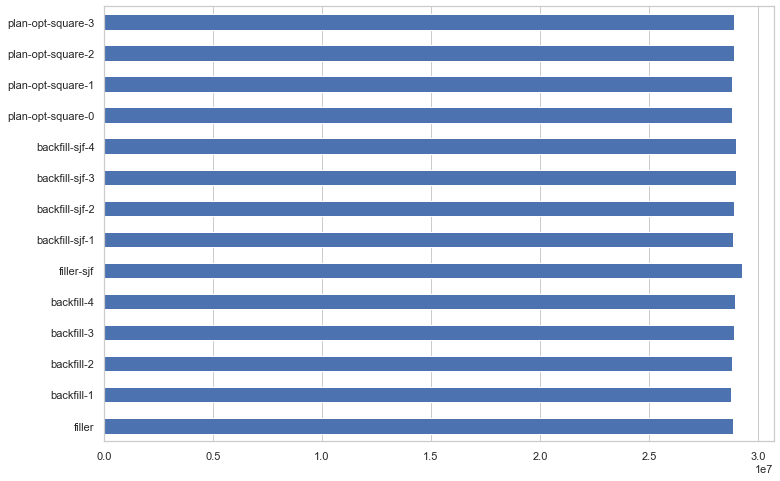

In [13]:
ax = metrics['makespan'].plot.barh(figsize=(12, 8))
ax.grid(axis='y')

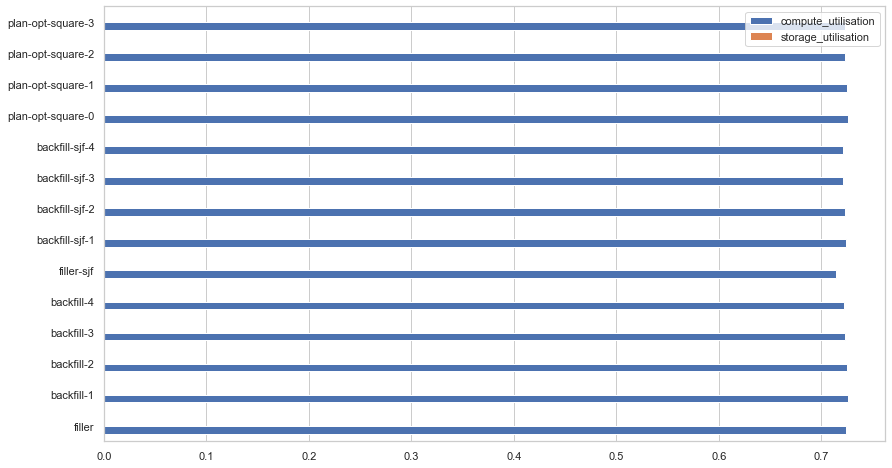

In [14]:
ax = metrics[['compute_utilisation', 'storage_utilisation']].plot.barh(figsize=(14, 8))
ax.grid(axis='y')

In [15]:
for schedule in jobsets.keys():
    jobsets[schedule].df = transform_jobset(schedule)

In [16]:
# rename schedules
new_jobsets = {}
for old_name, new_name in zip(schedule_names, new_names):
    new_jobsets[new_name] = jobsets[old_name]
schedule_names = new_names
jobsets = new_jobsets

In [17]:
metrics_df = create_all_metrics_df()
metrics_df

,schedule,waiting_time,turnaround_time,slowdown,bounded_slowdown
0,filler,0.000000,199.376073,1.000000,1.000000
1,filler,0.000000,4.308942,1.000000,1.000000
2,filler,20404.149818,20844.808064,47.303797,34.741347
3,filler,19886.808264,27010.970858,3.791459,3.791459
4,filler,18451.149818,25312.192257,3.689263,3.689263
...,...,...,...,...,...
28448,plan-square-3,17783.903948,38728.038377,1.849111,1.849111
28449,plan-square-3,91075.000000,105338.777722,7.385055,7.385055
28450,plan-square-3,74615.737685,88883.849574,6.229545,6.229545
28451,plan-square-3,54273.264347,67384.807711,5.139350,5.139350


In [18]:
metrics_df.groupby('schedule').describe().T

schedule                   backfill-1     backfill-2     backfill-3  \
waiting_time     count   28453.000000   28453.000000   28453.000000   
                 mean    14561.065035   28181.505846   39652.268298   
                 std     40986.225159   70190.993739   85886.261414   
                 min         0.000000       0.000000       0.000000   
                 25%         0.000000       0.000000       0.000000   
                 50%         4.241377    2282.251344    5362.282777   
                 75%      9314.759640   21109.294980   34124.599086   
                 max    660955.100730  768892.699002  824675.851323   
turnaround_time  count   28453.000000   28453.000000   28453.000000   
                 mean    23345.399482   36966.373238   48437.170822   
                 std     48033.555144   76071.171867   92163.627458   
                 min         0.090400       0.127128       0.194254   
                 25%       177.306547     517.002427     933.814557   
                 50%      5973.278602    9705.098701   12685.960551   
                 75%     23951.637759   37402.155864   48612.495678   
                 max    676106.711923  806074.869155  861055.177712   
slowdown         count   28453.000000   28453.000000   28453.000000   
                 mean      181.475132     379.497229     492.072322   
                 std      1123.992847    2341.281871    2844.704821   
                 min         1.000000       1.000000       1.000000   
                 25%         1.000000       1.000000       1.000000   
                 50%         1.002834       1.808361       2.921718   
                 75%         6.790060      23.896439      51.076120   
                 max     72686.529312  110472.280329  238508.205241   
bounded_slowdown count   28453.000000   28453.000000   28453.000000   
                 mean       10.968556      18.884825      25.406169   
                 std        41.719335      67.251284      81.089087   
                 min         1.000000       1.000000       1.000000   
                 25%         1.000000       1.000000       1.000000   
                 50%         1.000000       1.482350       2.279658   
                 75%         3.626315       8.718430      13.368168   
                 max      1102.083512    1202.826978    1374.667690   

schedule                   backfill-4  backfill-sjf-1  backfill-sjf-2  \
waiting_time     count   28453.000000    28453.000000    28453.000000   
                 mean    62012.057027    13909.254387    25782.125114   
                 std    129468.264675    44828.083931    75318.337967   
                 min         0.000000        0.000000        0.000000   
                 25%         0.000000        0.000000        0.000000   
                 50%      9673.835534        0.000000      545.626326   
                 75%     50018.826962     5567.048777    11546.469481   
                 max    872138.367277   637068.798290   854185.080736   
turnaround_time  count   28453.000000    28453.000000    28453.000000   
                 mean    70796.830393    22694.049249    34566.996646   
                 std    135384.895745    51779.385912    81573.854453   
                 min         0.194304        0.090400        0.125148   
                 25%      2059.348500      117.738795      251.300566   
                 50%     16799.650236     4347.495695     6262.468079   
                 75%     62798.668433    18738.767134    27661.135503   
                 max    911374.087893   674253.910261   857658.318897   
slowdown         count   28453.000000    28453.000000    28453.000000   
                 mean      810.205079      109.501551      198.405990   
                 std      4235.865027      725.026637     1200.720087   
                 min         1.000000        1.000000        1.000000   
                 25%         1.000000        1.000000        1.000000   
                 50%         5.896874        1.000

In [19]:
waiting_times = create_metric_df('waiting_time')
waiting_times.describe()

,filler,backfill-1,backfill-2,backfill-3,backfill-4,filler-sjf,backfill-sjf-1,backfill-sjf-2,backfill-sjf-3,backfill-sjf-4,plan-square-0,plan-square-1,plan-square-2,plan-square-3
count,2.845300e+04,28453.000000,28453.000000,28453.000000,28453.000000,2.845300e+04,28453.000000,28453.000000,2.845300e+04,2.845300e+04,2.845300e+04,28453.000000,28453.000000,28453.000000
mean,2.084075e+04,14561.065035,28181.505846,39652.268298,62012.057027,3.278832e+04,13909.254387,25782.125114,4.514814e+04,8.978419e+04,1.106503e+04,13257.144716,25871.748676,39452.896265
std,1.435025e+05,40986.225159,70190.993739,85886.261414,129468.264675,4.840707e+05,44828.083931,75318.337967,1.232222e+05,2.433150e+05,4.176127e+04,36717.837938,66546.175999,95755.540851
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
50%,0.000000e+00,4.241377,2282.251344,5362.282777,9673.835534,0.000000e+00,0.000000,545.626326,1.823515e+03,3.777045e+03,5.871158e+01,178.575573,1531.774237,2953.187544
75%,4.815074e+03,9314.759640,21109.294980,34124.599086,50018.826962,1.841709e+03,5567.048777,11546.469481,2.215991e+04,3.260987e+04,5.426275e+03,8446.641207,16340.999740,23819.484278
max,5.938432e+06,660955.100730,768892.699002,824675.851323,872138.367277,2.361754e+07,637068.798290,854185.080736,1.019981e+06,1.555018e+06,1.340607e+06,571719.565917,640813.382614,701921.076732


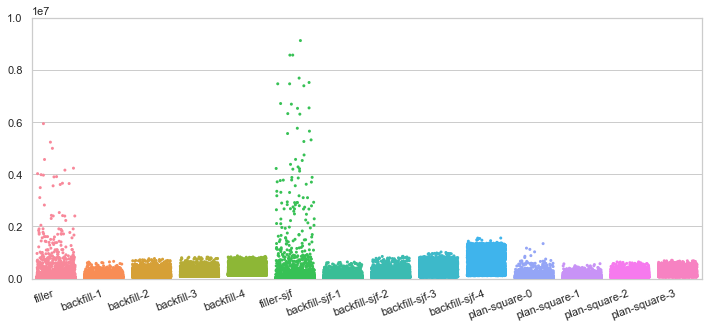

In [67]:
# Scatterplot, outliers
largest = pd.concat([metrics_df[metrics_df.schedule == schedule][['schedule', 'waiting_time']].nlargest(n=4000, columns='waiting_time') for schedule in schedule_names])
# with sns.plotting_context('talk'):
# fig, ax = plt.subplots(figsize=(14.4,4))
# fig, ax = plt.subplots(figsize=(4,4))
# fig, ax = plt.subplots(figsize=(12,5))
fig, ax = plt.subplots(figsize=(12,4.8))
sns.stripplot(data=largest, x='schedule', y='waiting_time', ax=ax, size=3, jitter=0.4)
ax.set_ylim(0)
ax.set_ylim(top=1*10**7)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, horizontalalignment='right', fontweight='light')
fig.savefig('../../images/results/depth_waiting-time_dist.pdf', bbox_inches='tight')
#     fig.savefig('../../images/results/best_io-aware_waiting-time_dist.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/plan_waiting-time_dist.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/window_waiting-time_dist.pdf', bbox_inches='tight')
#     fig.savefig('../../images/results/maxutil_waiting-time_dist.pdf', bbox_inches='tight')

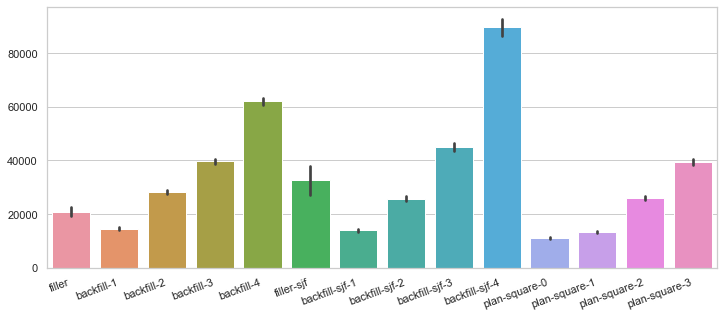

In [65]:
# Mean, logscale
# fig, ax = plt.subplots(figsize=(7.2,4))
# fig, ax = plt.subplots(figsize=(4,4))
# fig, ax = plt.subplots(figsize=(12,5))
fig, ax = plt.subplots(figsize=(12,4.8))
sns.barplot(data=waiting_times, ax=ax)
# ax.set_ylim(top=18000)
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, horizontalalignment='right', fontweight='light')
fig.savefig('../../images/results/depth_waiting-time_mean.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/best_io-aware_waiting-time_mean.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/plan_waiting-time_mean.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/window_waiting-time_mean.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/maxutil_waiting-time_mean.pdf', bbox_inches='tight')

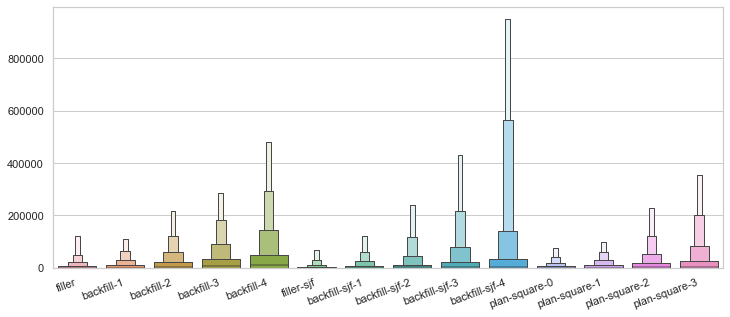

In [66]:
# Boxenplot
# fig, ax = plt.subplots(figsize=(7.2,4))
# fig, ax = plt.subplots(figsize=(4,4))
# fig, ax = plt.subplots(figsize=(12,5))
fig, ax = plt.subplots(figsize=(12,4.8))
sns.boxenplot(data=waiting_times, k_depth=4, showfliers=False, ax=ax)
# ax.set_yscale('log')
ax.set_ylim(0)
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, horizontalalignment='right', fontweight='light')
fig.savefig('../../images/results/depth_waiting-time_boxen.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/best_io-aware_waiting-time_boxen.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/plan_waiting-time_boxen.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/window_waiting-time_boxen.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/maxutil_waiting-time_boxen.pdf', bbox_inches='tight')

In [72]:
turnaround_times = create_metric_df('turnaround_time')
turnaround_times.describe()

,filler,backfill-1,backfill-2,backfill-3,backfill-4,filler-sjf,backfill-sjf-1,backfill-sjf-2,backfill-sjf-3,backfill-sjf-4,plan-square-0,plan-square-1,plan-square-2,plan-square-3
count,2.845300e+04,28453.000000,28453.000000,28453.000000,28453.000000,2.845300e+04,28453.000000,28453.000000,2.845300e+04,2.845300e+04,2.845300e+04,28453.000000,28453.000000,28453.000000
mean,2.962341e+04,23345.399482,36966.373238,48437.170822,70796.830393,4.157136e+04,22694.049249,34566.996646,5.393335e+04,9.856932e+04,1.984946e+04,22042.294718,34657.268493,48238.084736
std,1.450631e+05,48033.555144,76071.171867,92163.627458,135384.895745,4.852011e+05,51779.385912,81573.854453,1.293546e+05,2.499985e+05,5.018029e+04,45145.216414,73830.134268,103021.192878
min,9.040000e-02,0.090400,0.127128,0.194254,0.194304,9.040000e-02,0.090400,0.125148,9.040000e-02,9.040000e-02,1.998960e-01,0.194362,0.090400,0.194254
25%,1.677004e+02,177.306547,517.002427,933.814557,2059.348500,8.774241e+01,117.738795,251.300566,4.349653e+02,7.975113e+02,1.632659e+02,156.780522,304.313611,543.607425
50%,5.219755e+03,5973.278602,9705.098701,12685.960551,16799.650236,3.256099e+03,4347.495695,6262.468079,8.329975e+03,1.015076e+04,4.443692e+03,5193.160798,7410.044275,8878.096297
75%,1.992174e+04,23951.637759,37402.155864,48612.495678,62798.668433,1.426837e+04,18738.767134,27661.135503,3.883182e+04,4.775512e+04,1.785824e+04,22251.684467,31748.900269,39569.310016
max,5.938612e+06,676106.711923,806074.869155,861055.177712,911374.087893,2.362687e+07,674253.910261,857658.318897,1.045342e+06,1.575610e+06,1.380499e+06,608900.759899,664014.009004,803841.349811


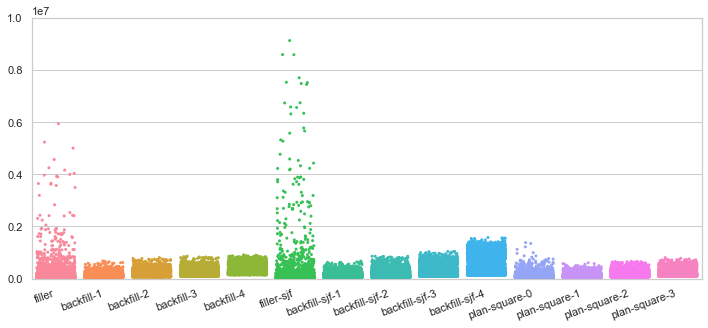

In [70]:
# Scatterplot, outliers
largest = pd.concat([metrics_df[metrics_df.schedule == schedule][['schedule', 'turnaround_time']].nlargest(n=4000, columns='turnaround_time') for schedule in schedule_names])
# with sns.plotting_context('talk'):
# fig, ax = plt.subplots(figsize=(14.4,4))
# fig, ax = plt.subplots(figsize=(4,4))
# fig, ax = plt.subplots(figsize=(12,5))
fig, ax = plt.subplots(figsize=(12,4.8))
sns.stripplot(data=largest, x='schedule', y='turnaround_time', ax=ax, size=3, jitter=0.4)
ax.set_ylim(0)
ax.set_ylim(top=1*10**7)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, horizontalalignment='right', fontweight='light')
fig.savefig('../../images/results/depth_turnaround-time_dist.pdf', bbox_inches='tight')
#     fig.savefig('../../images/results/best_io-aware_turnaround-time_dist.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/plan_turnaround-time_dist.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/window_turnaround-time_dist.pdf', bbox_inches='tight')
#     fig.savefig('../../images/results/maxutil_turnaround-time_dist.pdf', bbox_inches='tight')

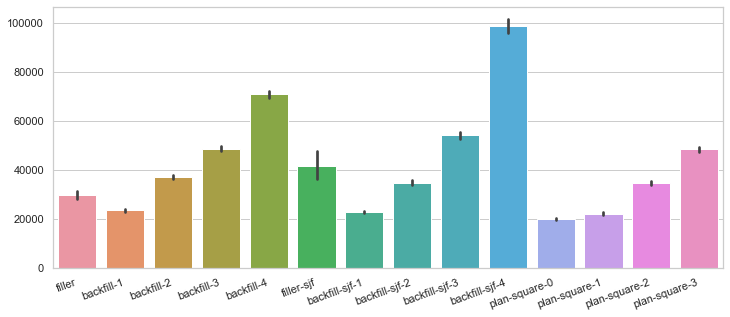

In [73]:
# Mean, logscale
# fig, ax = plt.subplots(figsize=(7.2,4))
# fig, ax = plt.subplots(figsize=(4,4))
# fig, ax = plt.subplots(figsize=(12,5))
fig, ax = plt.subplots(figsize=(12,4.8))
sns.barplot(data=turnaround_times, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, horizontalalignment='right', fontweight='light')
fig.savefig('../../images/results/depth_turnaround-time_mean.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/best_io-aware_turnaround-time_mean.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/plan_turnaround-time_mean.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/window_turnaround-time_mean.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/maxutil_turnaround-time_mean.pdf', bbox_inches='tight')

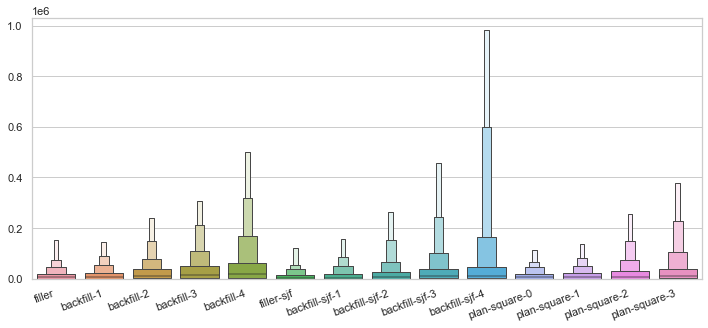

In [74]:
# Boxenplot
# fig, ax = plt.subplots(figsize=(12,8))
# fig, ax = plt.subplots(figsize=(7.2,4))
# fig, ax = plt.subplots(figsize=(4,4))
# fig, ax = plt.subplots(figsize=(12,5))
fig, ax = plt.subplots(figsize=(12,4.8))
sns.boxenplot(data=turnaround_times, k_depth=4, showfliers=False, ax=ax)
ax.set_ylim(0)
# ax.set_ylim(top=160000)
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, horizontalalignment='right', fontweight='light')
fig.savefig('../../images/results/depth_turnaround-time_boxen.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/best_io-aware_turnaround-time_boxen.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/plan_turnaround-time_boxen.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/window_turnaround-time_boxen.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/maxutil_turnaround-time_boxen.pdf', bbox_inches='tight')

In [75]:
slowdown = create_metric_df('stretch')
slowdown.describe()

,filler,backfill-1,backfill-2,backfill-3,backfill-4,filler-sjf,backfill-sjf-1,backfill-sjf-2,backfill-sjf-3,backfill-sjf-4,plan-square-0,plan-square-1,plan-square-2,plan-square-3
count,28453.000000,28453.000000,28453.000000,28453.000000,28453.000000,28453.000000,28453.000000,28453.000000,28453.000000,28453.000000,28453.000000,28453.000000,28453.000000,28453.000000
mean,197.498080,181.475132,379.497229,492.072322,810.205079,83.537569,109.501551,198.405990,364.526406,578.538290,105.808894,145.251688,251.294836,358.966692
std,1562.150931,1123.992847,2341.281871,2844.704821,4235.865027,1010.222907,725.026637,1200.720087,2778.593545,4186.559921,1419.005706,1140.457913,1630.286521,3006.968643
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,1.002834,1.808361,2.921718,5.896874,1.000000,1.000000,1.253055,1.786988,3.125270,1.020529,1.079480,1.647347,2.332173
75%,4.992995,6.790060,23.896439,51.076120,108.198168,2.164030,4.401651,11.350863,23.586349,53.683655,4.777497,5.566311,14.205765,25.810328
max,126152.232149,72686.529312,110472.280329,238508.205241,229461.574861,108693.748455,48479.460646,79713.454910,238062.812875,188516.985065,181986.004396,100385.436153,102167.238732,223495.534791


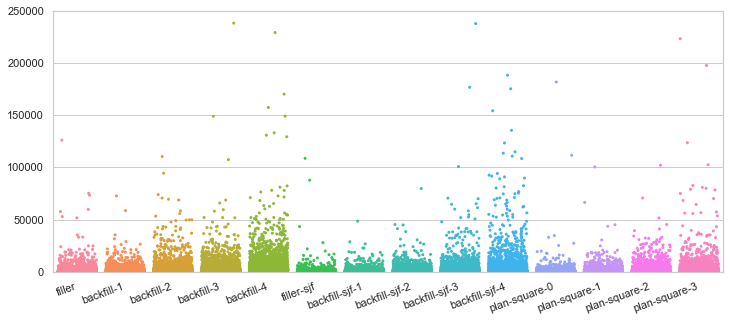

In [76]:
# Scatterplot, outliers
largest = pd.concat([metrics_df[metrics_df.schedule == schedule][['schedule', 'slowdown']].nlargest(n=4000, columns='slowdown') for schedule in schedule_names])
# with sns.plotting_context('talk'):
#     fig, ax = plt.subplots(figsize=(14.4,4))
# fig, ax = plt.subplots(figsize=(4,4))
# fig, ax = plt.subplots(figsize=(12,5))
fig, ax = plt.subplots(figsize=(12,4.8))
sns.stripplot(data=largest, x='schedule', y='slowdown', ax=ax, size=3, jitter=0.4)
ax.set_ylim(0)
#     ax.set_ylim(top=250000)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, horizontalalignment='right', fontweight='light')
fig.savefig('../../images/results/depth_slowdown_dist.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/best_io-aware_slowdown_dist.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/plan_slowdown_dist.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/window_slowdown_dist.pdf', bbox_inches='tight')
#     fig.savefig('../../images/results/maxutil_slowdown_dist.pdf', bbox_inches='tight')

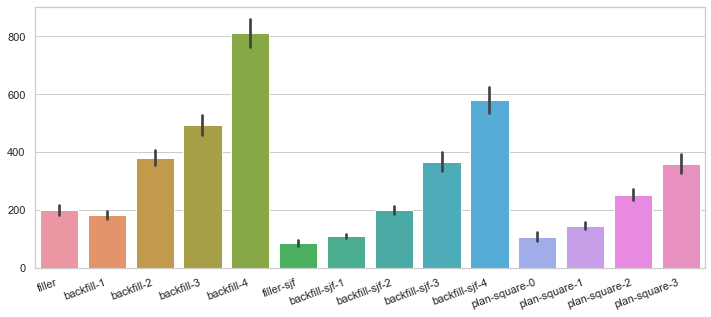

In [77]:
# Mean, logscale
# fig, ax = plt.subplots(figsize=(7.2,4))
# fig, ax = plt.subplots(figsize=(4,4))
# fig, ax = plt.subplots(figsize=(12,5))
fig, ax = plt.subplots(figsize=(12,4.8))
sns.barplot(data=slowdown, ax=ax)
# ax.set_ylim(top=200)
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, horizontalalignment='right', fontweight='light')
fig.savefig('../../images/results/depth_slowdown_mean.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/best_io-aware_slowdown_mean.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/plan_slowdown_mean.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/window_slowdown_mean.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/maxutil_slowdown_mean.pdf', bbox_inches='tight')

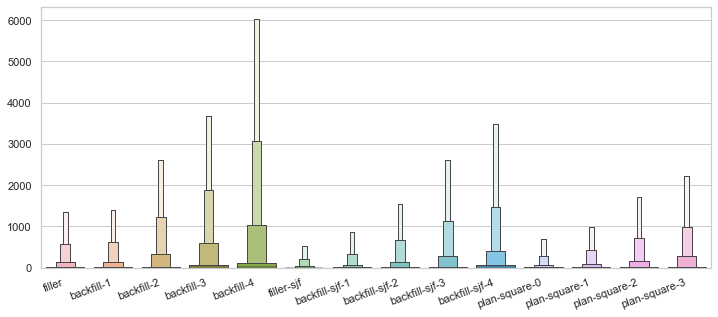

In [78]:
# Boxenplot
# fig, ax = plt.subplots(figsize=(12,8))
# fig, ax = plt.subplots(figsize=(7.2,4))
# fig, ax = plt.subplots(figsize=(4,4))
# fig, ax = plt.subplots(figsize=(12,5))
fig, ax = plt.subplots(figsize=(12,4.8))
sns.boxenplot(data=slowdown, k_depth=4, showfliers=False, ax=ax)
ax.set_ylim(0)
# ax.set_ylim(top=1400)
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, horizontalalignment='right', fontweight='light')
fig.savefig('../../images/results/depth_slowdown_boxen.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/best_io-aware_slowdown_boxen.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/plan_slowdown_boxen.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/window_slowdown_boxen.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/maxutil_slowdown_boxen.pdf', bbox_inches='tight')

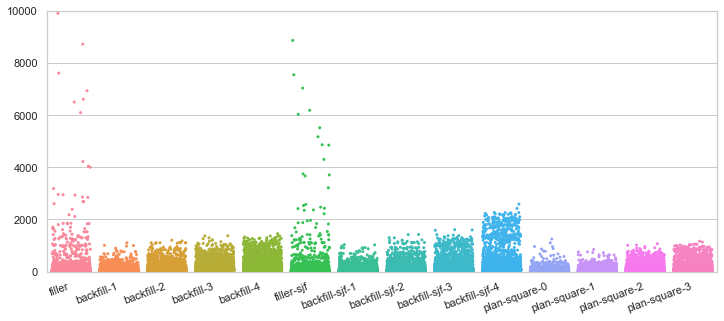

In [81]:
# Scatterplot, outliers
largest = pd.concat([metrics_df[metrics_df.schedule == schedule][['schedule', 'bounded_slowdown']].nlargest(n=4000, columns='bounded_slowdown') for schedule in schedule_names])
# with sns.plotting_context('talk'):
#     fig, ax = plt.subplots(figsize=(14.4,4))
# fig, ax = plt.subplots(figsize=(4,4))
# fig, ax = plt.subplots(figsize=(12,5))
fig, ax = plt.subplots(figsize=(12,4.8))
sns.stripplot(data=largest, x='schedule', y='bounded_slowdown', ax=ax, size=3, jitter=0.4)
ax.set_ylim(0)
ax.set_ylim(top=10000)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, horizontalalignment='right', fontweight='light')
fig.savefig('../../images/results/depth_bounded-slowdown_dist.pdf', bbox_inches='tight')
#     fig.savefig('../../images/results/best_io-aware_bounded-slowdown_dist.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/plan_bounded-slowdown_dist.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/window_bounded-slowdown_dist.pdf', bbox_inches='tight')
#     fig.savefig('../../images/results/maxutil_bounded-slowdown_dist.pdf', bbox_inches='tight')

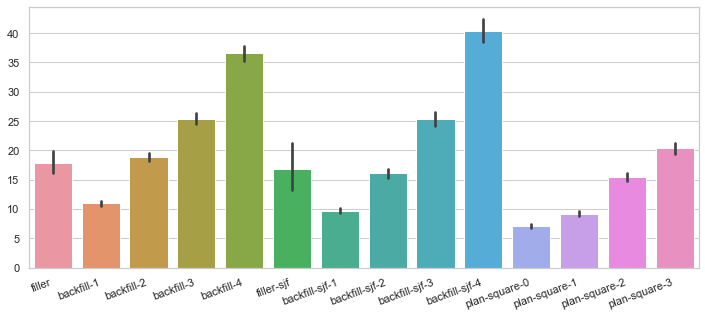

In [82]:
# Mean, logscale
# fig, ax = plt.subplots(figsize=(7.2,4))
# fig, ax = plt.subplots(figsize=(4,4))
# fig, ax = plt.subplots(figsize=(12,5))
fig, ax = plt.subplots(figsize=(12,4.8))
sns.barplot(data=metrics_df, x='schedule', y='bounded_slowdown', ax=ax)
# ax.set_ylim(top=12)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, horizontalalignment='right', fontweight='light')
fig.savefig('../../images/results/depth_bounded-slowdown_mean.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/best_io-aware_bounded-slowdown_mean.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/plan_bounded-slowdown_mean.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/window_bounded-slowdown_mean.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/maxutil_bounded-slowdown_mean.pdf', bbox_inches='tight')

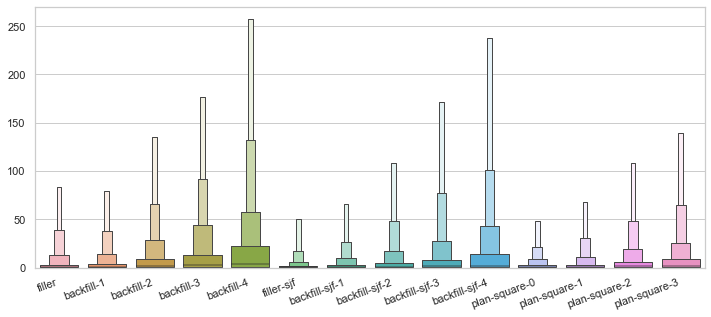

In [83]:
# Boxenplot
# fig, ax = plt.subplots(figsize=(12,8))
# fig, ax = plt.subplots(figsize=(7.2,4))
# fig, ax = plt.subplots(figsize=(4,4))
# fig, ax = plt.subplots(figsize=(12,5))
fig, ax = plt.subplots(figsize=(12,4.8))
sns.boxenplot(data=metrics_df, x='schedule', y='bounded_slowdown', k_depth=4, showfliers=False, ax=ax)
ax.set_ylim(0)
# ax.set_ylim(top=80)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, horizontalalignment='right', fontweight='light')
fig.savefig('../../images/results/depth_bounded-slowdown_boxen.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/best_io-aware_bounded-slowdown_boxen.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/plan_bounded-slowdown_boxen.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/window_bounded-slowdown_boxen.pdf', bbox_inches='tight')
# fig.savefig('../../images/results/maxutil_bounded-slowdown_boxen.pdf', bbox_inches='tight')

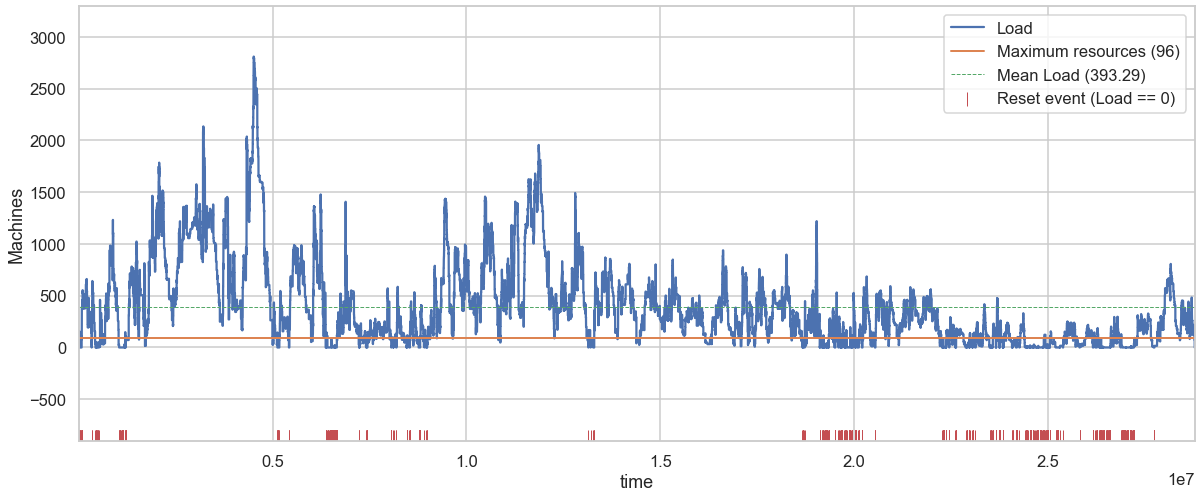

In [39]:
fig, ax = plt.subplots(figsize=(20,8))
visu.legacy.plot_load(jobsets['backfill-1'].queue, nb_resources=96, ax=ax)

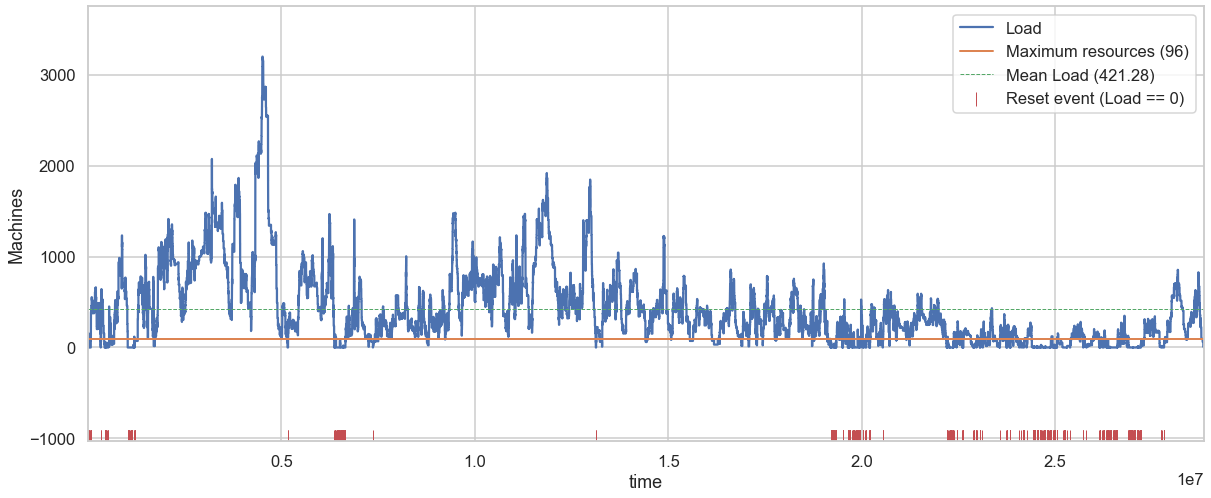

In [67]:
fig, ax = plt.subplots(figsize=(20,8))
visu.legacy.plot_load(jobsets['backfill-sjf-1'].queue, nb_resources=96, ax=ax)

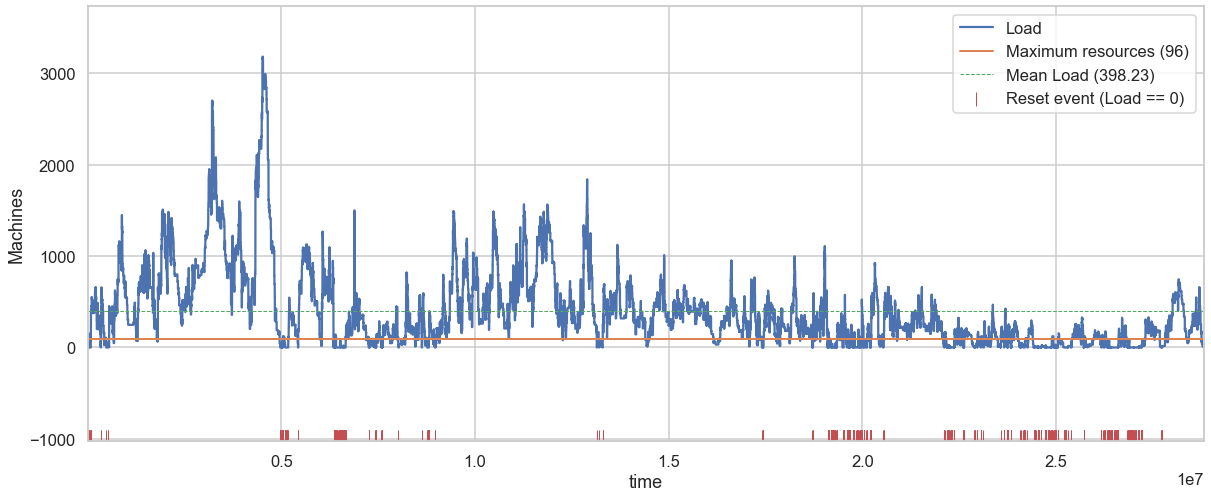

In [40]:
fig, ax = plt.subplots(figsize=(20,8))
visu.legacy.plot_load(jobsets['maxutil-opt-10-1'].queue, nb_resources=96, ax=ax)

In [50]:
metrics_df

,schedule,waiting_time,turnaround_time,stretch,bounded_slowdown
0,backfill-1,0.000000,199.376073,1.000000,1.000000
1,backfill-1,0.000000,4.308942,1.000000,1.000000
2,backfill-1,13826.769776,14308.788796,29.685112,23.847981
3,backfill-1,15751.293061,22887.347058,3.207283,3.207283
4,backfill-1,11873.769776,18749.659305,2.726870,2.726870
...,...,...,...,...,...
28448,plan-opt-square-0,22006.019438,42961.050082,2.050154,2.050154
28449,plan-opt-square-0,26814.138336,41061.745360,2.882010,2.882010
28450,plan-opt-square-0,46346.134294,60616.751580,4.247661,4.247661
28451,plan-opt-square-0,42325.405291,55433.724858,4.228896,4.228896
